In [1]:
import choix
import networkx as nx
import numpy as np
import pandas as pd
import itertools, difflib, progressbar, random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('./Data_DummyQuestions.xlsx')
print(df.shape)
df.head()

(174, 2)


,ID,Question
0,0,Item 0
1,1,Item 1
2,2,Item 2
3,3,Item 3
4,4,Item 4


In [3]:
%%time
vec_combs_iterator = itertools.combinations(df['ID'],2)
vec_combs = list(vec_combs_iterator)

CPU times: user 2.46 ms, sys: 609 µs, total: 3.07 ms
Wall time: 3.19 ms


In [4]:
df_combs = pd.DataFrame(vec_combs)
df_combs.columns = ['A','B']
np.random.seed(seed=45)
df_combs['Outcome'] = np.random.randint(0,2,size=df_combs.shape[0])
df_combs.head()

,A,B,Outcome
0,0,1,1
1,0,2,0
2,0,3,1
3,0,4,0
4,0,5,0


# Pairwise Simulation:

In [5]:
def get_winning_values(df):
    vec_pairs = []
    for i,row in df.iterrows():
        tmp_a = row['A']
        tmp_b = row['B']
        if(row['Outcome']==0):
            vec_pairs.append((tmp_a,tmp_b))
        else:
            vec_pairs.append((tmp_b,tmp_a))
    return(vec_pairs)

In [6]:
%%time
n_items = df.shape[0]
vec_groundtruth = get_winning_values(df_combs)
print(len(vec_groundtruth))
params_groundtruth = choix.ilsr_pairwise(n_items,vec_groundtruth)
print('Ranking (worst to best) for sample size n={n}:\n'.format(n='All'),np.argsort(params_groundtruth))

15051
Ranking (worst to best) for sample size n=All:
 [ 57  17 150  40 161  15  71  29  21  10 148 133 173 129  74  11 119 144
 157  63 104  95 124  54 107  34  20  84 169  41  94   8  62 101  35  49
  80   2 139   4   6  68  25 170  50 122  19 147  78 140 115  65 146  96
   9 163 136  87  85  16 102 143  24 121  47  88  55  64 126  23  89  82
   0  61 128 171 142 172  77  43  26   7 160  72  32  37 113  45 153  38
 112 127  28  44 145 111   5  56   3  42 162 159  22  13 109  97   1 156
 131 137  51 158 110  14 152  76  52  12  60 141  98  70  86  27  30 155
 106  18  59  66 166  83  53  90 123 108 135  73 100 114 164  79 134  91
 120  92  75  36 132 149 125 116 105  48  39 103 165 138  99 151 167 118
  46  69 130  58  81 168  33  31  67 154  93 117]
CPU times: user 2.85 s, sys: 57.3 ms, total: 2.91 s
Wall time: 2.82 s


In [7]:
%%time
is_print = False
is_break = False
vec_sample_sizes = list(range(50,16000,25))
vec_n = []
vec_sim_overall = []
vec_sim_3 = []
vec_sim_5 = []
vec_sim_10 = []
vec_sim_15 = []
vec_sorted_groundtruth = np.argsort(params_groundtruth)
viz_bar = progressbar.ProgressBar(max_value=len(vec_sample_sizes)).start()
for i,val_sample_size in enumerate(vec_sample_sizes):
    random.seed(45)
    if(val_sample_size>=len(vec_groundtruth)):
        val_sample_size = len(vec_groundtruth)
        is_break = True
    vec_sample = random.sample(vec_groundtruth,k=val_sample_size)
    params_sample = choix.ilsr_pairwise(n_items,vec_sample,alpha=0.01)
    if(is_print==True):
        print('Ranking (worst to best) for sample size n={n}:\n'.format(n=val_sample_size),np.argsort(params_sample))
    vec_sorted_sample = np.argsort(params_sample)
    vec_sim_overall.append(difflib.SequenceMatcher(a=vec_sorted_groundtruth,b=vec_sorted_sample).ratio())
    vec_sim_3.append(difflib.SequenceMatcher(a=vec_sorted_groundtruth[0:3],b=vec_sorted_sample[0:3]).ratio())
    vec_sim_5.append(difflib.SequenceMatcher(a=vec_sorted_groundtruth[0:5],b=vec_sorted_sample[0:5]).ratio())
    vec_sim_10.append(difflib.SequenceMatcher(a=vec_sorted_groundtruth[0:10],b=vec_sorted_sample[0:10]).ratio())
    vec_sim_15.append(difflib.SequenceMatcher(a=vec_sorted_groundtruth[0:15],b=vec_sorted_sample[0:15]).ratio())
    vec_n.append(val_sample_size)
    viz_bar.update(i)
    if(is_break):
        break
viz_bar.finish()

100% (638 of 638) |######################| Elapsed Time: 0:01:59 Time:  0:01:59


CPU times: user 5min 14s, sys: 25.1 s, total: 5min 39s
Wall time: 1min 59s


<AxesSubplot:xlabel='SampleSize'>

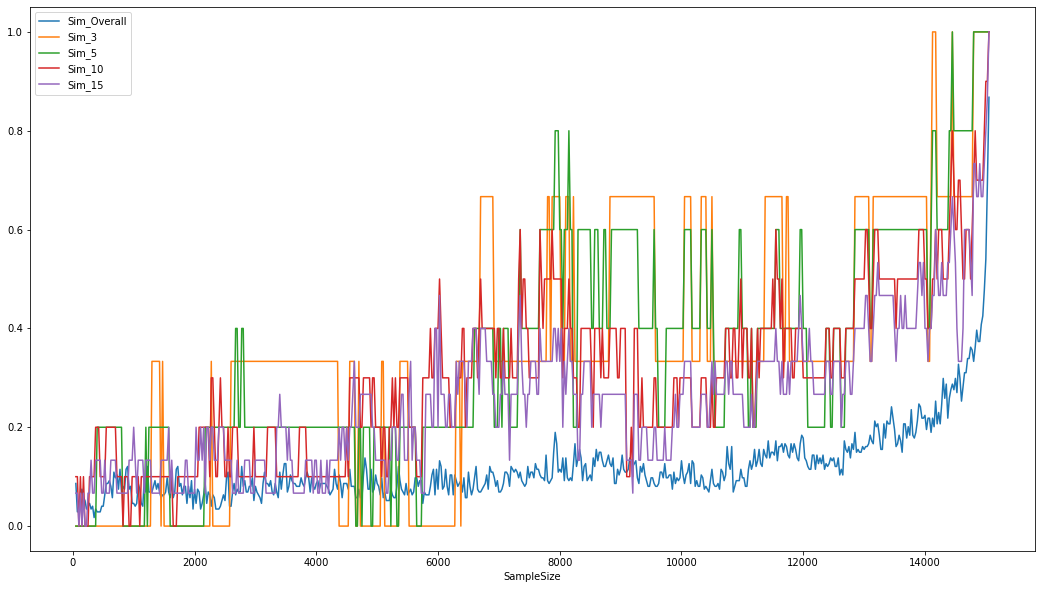

In [9]:
df_experiment = pd.DataFrame({'SampleSize':vec_n,'Sim_Overall':vec_sim_overall,'Sim_3':vec_sim_3,'Sim_5':vec_sim_5,'Sim_10':vec_sim_10,'Sim_15':vec_sim_15})
df_experiment.plot(x='SampleSize',y=['Sim_Overall','Sim_3','Sim_5','Sim_10','Sim_15'],figsize=(18,10))

In [8]:
print('Based on top two results from groundtruth...')
prob_1_wins,prob_2_wins = choix.probabilities([np.argsort(params_groundtruth)[0],np.argsort(params_groundtruth)[1]],params_groundtruth)
print('GROUNDTRUTH: Prob({i} wins over {j}): {p:.2f}'.format(i=np.argsort(params_groundtruth)[0],j=np.argsort(params_groundtruth)[1],p=prob_1_wins))

prob_1_wins,prob_2_wins = choix.probabilities([np.argsort(params_groundtruth)[0],np.argsort(params_groundtruth)[1]],params_sample)
print('SAMPLE: Prob({i} wins over {j}): {p:.2f}'.format(i=np.argsort(params_groundtruth)[0],j=np.argsort(params_groundtruth)[1],p=prob_1_wins))

print('\nBased on top two results from sample with n={n}...'.format(n=val_sample_size))
prob_1_wins,prob_2_wins = choix.probabilities([np.argsort(params_sample)[0],np.argsort(params_sample)[1]],params_groundtruth)
print('GROUNDTRUTH: Prob({i} wins over {j}): {p:.2f}'.format(i=np.argsort(params_sample)[0],j=np.argsort(params_sample)[1],p=prob_1_wins))

prob_1_wins,prob_2_wins = choix.probabilities([np.argsort(params_sample)[0],np.argsort(params_sample)[1]],params_sample)
print('SAMPLE: Prob({i} wins over {j}): {p:.2f}'.format(i=np.argsort(params_sample)[0],j=np.argsort(params_sample)[1],p=prob_1_wins))

Based on top two results from groundtruth...
GROUNDTRUTH: Prob(57 wins over 17): 0.50
SAMPLE: Prob(57 wins over 17): 0.50

Based on top two results from sample with n=15051...
GROUNDTRUTH: Prob(57 wins over 17): 0.50
SAMPLE: Prob(57 wins over 17): 0.50


# Top Rankings Lists:

In [18]:
n_items = df.shape[0]

In [24]:
np.random.seed(45)
vec_votes = []
for i in range(0,15,1):
    vec_votes.append(np.random.randint(n_items,size=10))
print(len(vec_votes))
print(vec_votes[0])
print(vec_votes[1])

15
[158 131 124  32  95 163  68 121 120  15]
[ 65 142  53  57 118  46   8 140 162 124]


In [23]:
params_ranking = choix.ilsr_rankings(n_items=n_items,data=vec_votes,alpha=0.01)
print('Ranking (worst to best) for sample size n={n}:\n'.format(n='All'),np.argsort(params_ranking))
print(params_ranking)

Ranking (worst to best) for sample size n=All:
 [ 52   2  15  66 160  77  98  48  60 162  55 124  70  90  12  31  57 120
 129  37 170 147  36 121   7  14 167  16 106 136 169  82  63  85  58  49
   5   8 105 140  95 108  56  11  54 111  81 149  29  88  46 163 172  39
  41 141 117  44  25  67 116 102  74  69   4  72  61  62 151 143  30 139
  91  47  45  64  28 171 109 100 101 148 113 137 166 122  26  38  84 128
  76  80 138 173 168 150 159 115 157 130 153 132 156 154 146 161   0   3
  33  40  50 104   1  79  13  83  89  73  96  99  10  35 125 112  21 133
 142 152  43   9 134  34 118 126 155 103  75 135 127  20  97   6  68  93
 110  53  23  94  92  17  87 145  32 158 131  59 165 107  18 164  42  78
 144 119  71  65  24  22 114  19 123  51  86  27]
[ 0.04803934  0.04803934 -1.02346773  0.04803934  0.04803934 -0.09131581
  0.25867907 -0.40825441 -0.09040632  0.08178031  0.04803934 -0.05237659
 -0.56154677  0.04803934 -0.36960832 -0.98018238 -0.23620032  0.31922201
  0.39370279  0.45322421  